# Create subsset dataset similar to WhatsUp (Caption Match)

In [1]:
import os
from pathlib import Path
from glob import glob

from PIL import Image
import matplotlib.pyplot as plt

In [2]:
demo_dataset_dir = Path("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo")
c1_dir = demo_dataset_dir / "single-dof-camera-motion-demo"
c2_dir = demo_dataset_dir / "obj-centered-view-shift-demo"

## C1 display

In [3]:
image_path_list = []
for dof_dir in c1_dir.iterdir():
    if dof_dir.is_dir():
        for scene_dir in dof_dir.iterdir():
            if scene_dir.is_dir():
                for seq_dir in scene_dir.iterdir():
                    if seq_dir.is_dir():
                        for pair_dir in seq_dir.iterdir():
                            if pair_dir.is_dir():
                                # src_dir = pair_dir / "src"
                                tgt_dir = pair_dir / "target"

                                tgt_image_file = next(tgt_dir.glob("*color.png"))

                                image_path_list.append(tgt_image_file)

                                # # show the image
                                # from IPython.display import Image, display
                                # display(Image(filename=str(tgt_image_file)))

                                # break

In [12]:
images = iter(image_path_list[-5:])

def _show_image(image_path):
    img = Image.open(image_path)
    info = f"""
    Image Information:
    - Format: {img.format}
    - Mode: {img.mode}
    - Size (WxH): {img.size[0]}x{img.size[1]} pixels
    - Resolution (DPI): {img.info.get('dpi', 'N/A')}
    """
    
    plt.imshow(img)
    plt.axis('off')
    plt.figtext(0.5, -0.02, info, va="center", ha='left', fontsize=10, bbox={'facecolor':'white', 'alpha':0.8, 'pad':1})
    plt.show()

### Iterate the image

In [50]:
i = 0
def _next(images):
    global i
    image_path = next(images)
    _show_image(image_path)
    i += 1
    print(f"Image {i} processed: {len(image_path_list) - i - 1} remaining.")
    return image_path


⚠️run below

In [49]:
image_path = _next(images)

StopIteration: 

### Curate QA-pair

In [17]:
image_path

PosixPath('/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/single-dof-camera-motion-demo/ty_significant/office/seq-03/000061-000096/target/frame-000096.color.png')

#### Select objects

⚠️run below

In [18]:
objs = []

while True:
    obj = input("Please select an object (type 'done' when finished): ")
    
    if obj.lower() == 'done':
        print("You have finished selecting objects.")
        break
    elif obj:
        objs.append(obj)
        print(f"Object '{obj}' added. Current objects: {objs}")
    else:
        print("Invalid input. Please enter a valid object name.")

print("Final list of selected objects:", objs)

Object 'Headphone' added. Current objects: ['Headphone']
Object 'Keyboard' added. Current objects: ['Headphone', 'Keyboard']
You have finished selecting objects.
Final list of selected objects: ['Headphone', 'Keyboard']


In [39]:
## if needed, inverse the order of 2 objs, create a new row
objs = objs[::-1] if len(objs) == 2 else objs

#### Curate captions with templates

In [19]:
one_obj_temp = [
    "{obj} is on the left side of the image",
    "{obj} is on the right side of the image",
    "{obj} is on the top of the image",
    "{obj} is on the bottom of the image",
]

two_obj_temp = [
    "{obj1} is on the left of {obj2}.",
    "{obj1} is on the right of {obj2}.",
    "{obj1} is above {obj2}.",
    "{obj1} is below {obj2}.",
    "{obj1} is in front of {obj2}.",
    "{obj1} is behind {obj2}.",
]

In [20]:
def _generate_captions(objs):
    captions = []
    if len(objs) == 1:
        for temp in one_obj_temp:
            caption = temp.format(obj=objs[0])
            captions.append(caption)
    elif len(objs) == 2:
        for temp in two_obj_temp:
            caption = temp.format(obj1=objs[0], obj2=objs[1])
            captions.append(caption)
    else:
        print("Please select one or two objects only.")
        return None
    return captions

⚠️run below

In [40]:
captions = _generate_captions(objs)
print(captions)

['Headphone is on the left of Keyboard.', 'Headphone is on the right of Keyboard.', 'Headphone is above Keyboard.', 'Headphone is below Keyboard.', 'Headphone is in front of Keyboard.', 'Headphone is behind Keyboard.']


#### Curate prompt

In [22]:
def _generate_prompt(captions: list) -> str:
    prompt_temp = """<input>
You are given an image, and a set of captions describing the relation of objects in the image.
</inputs>

<task>
You need to select the caption that best describes the image.
</task>

<captions>
{ans_candidates}
</captions>

<output-format>
Please output the index of the selected caption in the <ans></ans> XML tag. Do not output any other text.
</output-format>"""

    ans_candidates = "\n".join([f"{i}. {cap}" for i, cap in enumerate(captions)])
    prompt = prompt_temp.format(ans_candidates=ans_candidates)
    return prompt

⚠️run below

In [41]:
prompt = _generate_prompt(captions)
print(prompt)

<input>
You are given an image, and a set of captions describing the relation of objects in the image.
</inputs>

<task>
You need to select the caption that best describes the image.
</task>

<captions>
0. Headphone is on the left of Keyboard.
1. Headphone is on the right of Keyboard.
2. Headphone is above Keyboard.
3. Headphone is below Keyboard.
4. Headphone is in front of Keyboard.
5. Headphone is behind Keyboard.
</captions>

<output-format>
Please output the index of the selected caption in the <ans></ans> XML tag. Do not output any other text.
</output-format>


#### Confirm the correct index and correct relationship

In [24]:
def _find_cor_rela(cap: str) -> str:
    if "left" in cap:
        return "left"
    elif "right" in cap:
        return "right"
    elif "top" in cap:
        return "top"
    elif "bottom" in cap:
        return "bottom"
    elif "front" in cap:
        return "front"
    elif "behind" in cap:
        return "behind"
    elif "above" in cap:
        return "above"
    elif "below" in cap:
        return "below"
    else:
        raise ValueError(f"Unknown relation in caption: {cap}")

⚠️run below

In [42]:
cor_idx = int(input("Please input the index of the correct caption: "))
if cor_idx < 0 or cor_idx >= len(captions):
    raise ValueError(f"Invalid index: {cor_idx}. It should be between 0 and {len(captions) - 1}.")

In [43]:
cor_rela = _find_cor_rela(captions[cor_idx])
print(f"cor idx: {cor_idx}\ncor relation: {cor_rela}")

cor idx: 0
cor relation: left


#### Shuffle the captions

In [27]:
import random
random.seed(42)  # For reproducibility

# after shuffling, we should inverse the index of the correct caption
def _find_cor_idx(cor_rela: str, captions: list) -> int:
    """
    the correct rela is inside one of the captions, find it
    """
    for i, cap in enumerate(captions):
        if cor_rela in cap:
            return i
    raise ValueError(f"Cannot find the correct relation '{cor_rela}' in the captions.")

⚠️run below

In [44]:
captions_shuf = captions.copy()
random.shuffle(captions_shuf)

prompt_shuf = _generate_prompt(captions_shuf)
cor_idx_shuf = _find_cor_idx(cor_rela, captions_shuf)

print(f"Shuffled captions: {captions_shuf}\nCor index: {cor_idx_shuf}\nThe cor caption: {captions_shuf[cor_idx_shuf]}")

Shuffled captions: ['Headphone is below Keyboard.', 'Headphone is on the right of Keyboard.', 'Headphone is above Keyboard.', 'Headphone is on the left of Keyboard.', 'Headphone is in front of Keyboard.', 'Headphone is behind Keyboard.']
Cor index: 3
The cor caption: Headphone is on the left of Keyboard.


In [45]:
row = {
    "img_path": str(image_path),

    "cap": captions,
    "prompt": prompt,
    "cor_idx": cor_idx,
    "cor_rela": cor_rela,

    "cap_shuf": captions_shuf,
    "promp_shuf": prompt_shuf,
    "cor_idx_shuf": cor_idx_shuf,
}

In [46]:
import jsonlines
with jsonlines.open("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/basic-rela.jsonl", mode='a') as writer:
    writer.write(row)

Visual the entire dataset

In [ ]:
import pandas as pd
df = pd.read_json("/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/demo/basic-rela.jsonl", lines=True)
df

,img_path,cap,prompt,cor_idx,cor_rela,cap_shuf,promp_shuf,cor_idx_shuf
0,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,[Fire Extinguisher is on the left of Yellow Si...,"<input>\nYou are given an image, and a set of ...",0,left,"[Fire Extinguisher is below Yellow Sign., Fire...","<input>\nYou are given an image, and a set of ...",1
1,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,[Yellow Sign is on the left of Fire Extinguish...,"<input>\nYou are given an image, and a set of ...",1,right,"[Yellow Sign is below Fire Extinguisher., Yell...","<input>\nYou are given an image, and a set of ...",1
2,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Fire Extinguisher is on the left of Plant., F...","<input>\nYou are given an image, and a set of ...",0,left,"[Fire Extinguisher is on the right of Plant., ...","<input>\nYou are given an image, and a set of ...",5
3,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Plant is on the left of Fire Extinguisher., P...","<input>\nYou are given an image, and a set of ...",1,right,"[Plant is on the right of Fire Extinguisher., ...","<input>\nYou are given an image, and a set of ...",0
4,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Computer is on the left side of the image, Co...","<input>\nYou are given an image, and a set of ...",2,top,"[Computer is on the top of the image, Computer...","<input>\nYou are given an image, and a set of ...",0
5,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Computer is on the left of Keyboard., Compute...","<input>\nYou are given an image, and a set of ...",5,behind,"[Computer is behind Keyboard., Computer is on ...","<input>\nYou are given an image, and a set of ...",0
6,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Keyboard is on the left of Computer., Keyboar...","<input>\nYou are given an image, and a set of ...",4,front,"[Keyboard is above Computer., Keyboard is on t...","<input>\nYou are given an image, and a set of ...",2
7,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Oranges is on the left of Mouse., Oranges is ...","<input>\nYou are given an image, and a set of ...",0,left,"[Oranges is below Mouse., Oranges is on the ri...","<input>\nYou are given an image, and a set of ...",2
8,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Mouse is on the left of Oranges., Mouse is on...","<input>\nYou are given an image, and a set of ...",1,right,"[Mouse is above Oranges., Mouse is on the righ...","<input>\nYou are given an image, and a set of ...",1
9,/home/u5u/kdeng.u5u/spatial-reasoning-of-LMs/d...,"[Shelf is on the left side of the image, Shelf...","<input>\nYou are given an image, and a set of ...",2,top,"[Shelf is on the right side of the image, Shel...","<input>\nYou are given an image, and a set of ...",3


<Axes: title={'center': 'Distribution of Correct Relations'}, ylabel='count'>

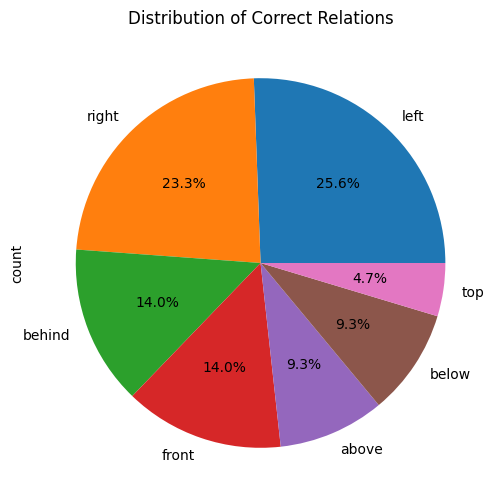

In [55]:
df.cor_rela.value_counts().plot(kind="pie", autopct="%1.1f%%", figsize=(8, 6), title="Distribution of Correct Relations")

## C2 display